<a href="https://colab.research.google.com/github/sunandhini96/ERA_S7/blob/main/ERA1S7_Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 3 :
Dataset : MNIST
Applied : for model_2 + step lr
(to improve performance )

In [6]:
!git clone "https://github.com/katipallyvig8899/ERA_7"

fatal: destination path 'ERA_7' already exists and is not an empty directory.


In [7]:
cd /content/ERA_7

/content/ERA_7


In [8]:
pwd

'/content/ERA_7'

In [9]:
!python model.py

In [10]:
from model import *

# Import Libraries

In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [12]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [13]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 186464924.31it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119110810.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70945317.05it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20934647.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_3().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
from torch.optim.lr_scheduler import StepLR

model =  Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10955826938152313 Batch_id=937 Accuracy=89.72: 100%|██████████| 938/938 [00:50<00:00, 18.70it/s]



Test set: Average loss: 0.0689, Accuracy: 9792/10000 (97.92%)

EPOCH: 1


Loss=0.04325434938073158 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [00:45<00:00, 20.72it/s]



Test set: Average loss: 0.0444, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.016473351046442986 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:44<00:00, 21.14it/s]



Test set: Average loss: 0.0490, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


Loss=0.014336732216179371 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:44<00:00, 21.23it/s]



Test set: Average loss: 0.0347, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.019359659403562546 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:45<00:00, 20.66it/s]



Test set: Average loss: 0.0332, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.056771453469991684 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:45<00:00, 20.75it/s]



Test set: Average loss: 0.0352, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.005922118667513132 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:44<00:00, 21.18it/s]



Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.020830675959587097 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:46<00:00, 20.14it/s]



Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.13904517889022827 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:44<00:00, 21.07it/s]



Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.010139815509319305 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:45<00:00, 20.79it/s]



Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.006060339976102114 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:45<00:00, 20.63it/s]



Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.019898783415555954 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:45<00:00, 20.74it/s]



Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.02482300065457821 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:44<00:00, 21.32it/s]



Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.005672494415193796 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:45<00:00, 20.70it/s]



Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.013979372568428516 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:44<00:00, 20.95it/s]



Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

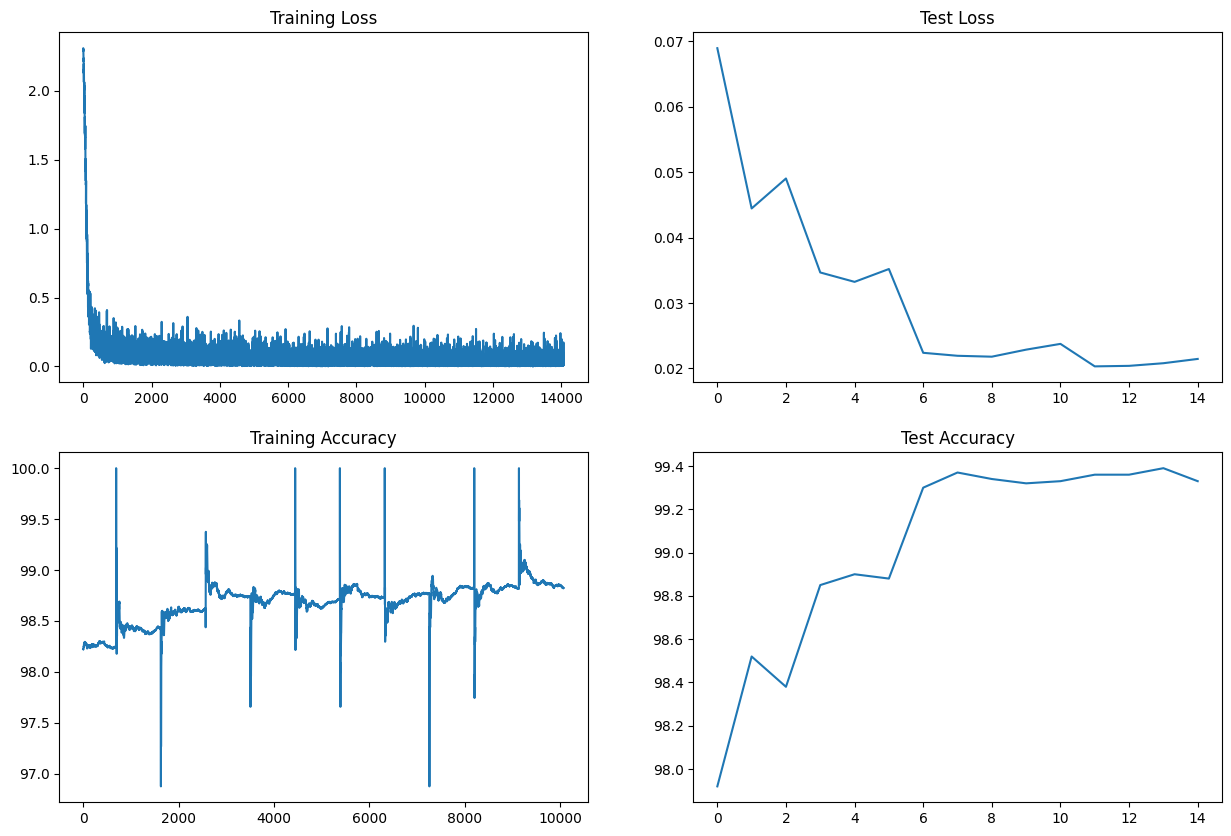

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
-> We added step lr to improve performance consistently.
## Results:
-> Parameters: 7.7k

-> Best Train Accuracy: 98.82

-> Best Test Accuracy: 99.39(13th epoch)

